# Libraries

In [1]:
import numpy as np
from numpy import exp, array, random, dot

import pandas as pd
import tensorflow as tf

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from google.colab import drive
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Loading Dataset

In [2]:
!gdown --id 19kmybD6rh63PHeF2AC7ebxPBDcyZE_fU

Downloading...
From: https://drive.google.com/uc?id=19kmybD6rh63PHeF2AC7ebxPBDcyZE_fU
To: /content/Dataset.csv
100% 480k/480k [00:00<00:00, 4.10MB/s]


In [3]:
df = pd.read_csv("/content/Dataset.csv")
df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


# Data visualization

In [4]:
df['Sentiment'].unique()

array([ 1, -1])

In [5]:
df.describe()

,Sentiment
count,5791.000000
mean,0.272664
std,0.962192
min,-1.000000
25%,-1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
# check the number of positive vs. negative tagged sentences

#df['Sentiment'].value_counts()

positives = df['Sentiment'][df.Sentiment == 1 ]
negatives = df['Sentiment'][df.Sentiment == -1 ]

print('Total length of the data is:         {}'.format(df.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         5791
No. of positve tagged sentences is:  3685
No. of negative tagged sentences is: 2106


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


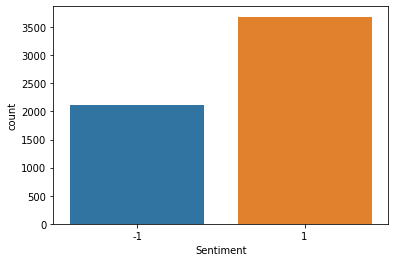

In [7]:
sns.countplot(df['Sentiment'])

In [8]:
# get a word count per of text
def word_count(words):
    return len(words.split())

In [9]:
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize, WordNetLemmatizer
import nltk
import re 
import string
import pickle
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
print(stop_words)


{'be', 'about', "you're", 'himself', "needn't", 'doesn', 'm', "doesn't", 'hadn', 'hers', "shan't", 'you', "haven't", "aren't", 'been', 'has', 'were', 'yours', 'on', 't', 'shouldn', 'isn', 'should', 'haven', 'had', "hasn't", 'mightn', 'him', 'then', 'they', 'at', "wouldn't", 'don', 'itself', 'an', 'as', 'against', 'no', 'will', 'his', 'than', 're', 'from', 'your', 'before', 'y', 'do', 'needn', 'aren', 'which', 'with', "it's", 'am', 'i', 'our', 'what', "don't", 'ma', 'below', 'up', 've', 'having', 'off', 'through', "isn't", 'or', "mustn't", "you'll", 'if', 'ourselves', "shouldn't", "couldn't", 'is', 'he', 'o', 'further', 'between', 'own', 'we', 'few', 'each', 'over', "weren't", 'while', 'to', 'why', 'very', 'here', 'myself', "hadn't", 'she', "you've", 'above', 'once', "wasn't", 'how', 'd', 'll', 'because', 'my', "she's", 'into', 'can', 'won', 'themselves', 'where', 'out', 'same', 'that', 'a', 'are', 'it', 'during', 'all', 'nor', 'when', 'shan', 'ours', 'me', 'didn', 'whom', 'mustn', 'the

In [11]:
word_list = list()
for i in range(len(df)):
    li = df.Text[i].split()
    for k in li:
        word_list.append(k)

In [12]:
from collections import Counter 
wordCounter = Counter(word_list)
countedWordDict = dict(wordCounter)
sortedWordDict = sorted(countedWordDict.items(),key = lambda x : x[1],reverse=True)
sortedWordDict[0:20]

[('the', 1796),
 ('to', 1668),
 ('a', 1280),
 ('on', 1032),
 ('of', 944),
 ('in', 891),
 ('AAP', 884),
 ('for', 868),
 ('and', 850),
 ('is', 811),
 ('-', 728),
 ('at', 541),
 ('this', 461),
 ('it', 454),
 ('I', 453),
 ('up', 357),
 ('user:', 340),
 ('from', 331),
 ('will', 330),
 ('be', 324)]

# Data Processing

In [13]:
seed = 170204067
torch.manual_seed(seed)

In [14]:
df["Sentiment"] = df["Sentiment"].replace(-1,0)
df["Sentiment"].value_counts()

1    3685
0    2106
Name: Sentiment, dtype: int64

In [15]:
#Checking if any null values present
(df.isnull().sum() / len(df))*100

Text         0.0
Sentiment    0.0
dtype: float64

In [16]:
ps = PorterStemmer()
lemma = WordNetLemmatizer()
stopwordSet = set(stopwords.words("english"))

> The Preprocessing steps taken are:

* Lower Casing: Each text is converted to lowercase.
* Removing URLs: Links starting with "http" or "https" or "www" are replaced by "".

* Removing Usernames: Replace @Usernames with word "". (eg: "@XYZ" to "")
* Removing Short Words: Words with length less than 2 are removed.
* Removing Stopwords: Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
* Lemmatizing: Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)

In [17]:

urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_text(text):
  # Lower Casing
    text = text.lower()
    text=text[1:]
    # Removing all URls 
    text = re.sub(urlPattern,'',text)
    # Removing all @username.
    text = re.sub(userPattern,'',text) 
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(text)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopwordSet]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)   

In [18]:
df['processed_text'] = df['Text'].apply(lambda x: process_text(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [19]:
print(df.shape)
df

(5791, 3)


,Text,Sentiment,processed_text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,ickers watchlist xide tit soq pnk cpw bpz aj t...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,ser aap movie 55 return feageed indicator 15 t...
2,user I'd be afraid to short AMZN - they are lo...,1,ser id afraid short amzn looking like nearmono...
3,MNTA Over 12.00,1,nta 1200
4,OI Over 21.37,1,2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,ndustry body cii said discoms likely suffer ne...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,gold price slip r 46000 investor book profit a...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,orkers bajaj auto agreed 10 wage cut period ap...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,sharemarket live sensex day high 600 point nif...


# Create the (B.O.W) bag of word model

In [20]:
cv = CountVectorizer(max_features = len(df))
X = cv.fit_transform(df['processed_text']).toarray()
y= df['Sentiment'].to_numpy()

#X = torch.from_numpy(X).type(torch.LongTensor)
#y = torch.from_numpy(y).type(torch.LongTensor)

X = torch.from_numpy(X)
y = torch.from_numpy(y)


## Split train and test

The Preprocessed Data is divided into 2 sets of data:

* Training Data: The dataset upon which the model would be trained on. Contains 80% data.
* Test Data: The dataset upon which the model would be tested against. Contains 20% data.




In [21]:
## Split the dataset into Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state = seed)

X_train = X_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

In [22]:

#BATCH_SIZE = 264

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Model Building <a id="7"></a>

**Neural Network**

In [23]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512) 
        self.layer_2 = nn.Linear(512, 128) 
        self.layer_3 = nn.Linear(128, 1)   
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout()
        # self.flatten = nn.Flatten()
       
     
  
        
    def forward(self, x):

        x = self.layer_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_2(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_3(x)
        logits = self.sigmoid(x)
        return logits

In [24]:
model = NeuralNetwork(len(df))
print(model)



NeuralNetwork(
  (layer_1): Linear(in_features=5791, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)


Optimization

In [25]:
"""
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

"""


import torch.optim as optim
optimizer = optim.Adam(model.parameters())

loss_fn = nn.BCEWithLogitsLoss()
model = model.to(device)
loss_fn = loss_fn.to(device)



We implement the function to calculate accuracy...

In [26]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [27]:

def trainModel(model, loss_fn, optimizer):
    model.train()

    batch = 256
    size = X_test.shape[0]

    loss = 0
    acc = 0
    

    for i in range(X_train.shape[0]):
      x, y = X_train[i], torch.tensor([y_train[i]], dtype=torch.float)
    
      # Compute prediction 
      pred = model(x)
      loss += loss_fn(pred,y)
      acc += binary_accuracy(pred,y)
      
      if i>0 and (i+1)%batch == 0:
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
         # print(f'Training Loss: {loss.item():.4f}', end="\r")
         # print(f'\tTraining Loss: {loss.item():.3f} | Training Acc: {acc.item()*100:.2f}%')
          loss = 0
          acc = 0
    print()
    return loss.item()/size, acc.item()/size




In [28]:
from numpy.lib.function_base import append


TP=[]
TN=[]
FP=[]
FN=[]
def testModel(model, loss_fn):
    model.eval()

    size = X_test.shape[0]

    loss = 0
    acc = 0



    with torch.no_grad():
      for i in range(X_test.shape[0]):
        x, y = X_test[i], torch.tensor([y_test[i]], dtype=torch.float)
    
        # Compute prediction error
        pred = model(x)
        if( (torch.round(pred)) == 1 and y== 0) :
           FP.append(1)
        if( (torch.round(pred)) == 0 and y== 1) :
           FN.append(1)
        if( (torch.round(pred)) == 1 and y== 1) :
           TP.append(1)
        if( (torch.round(pred)) == 0 and y== 0) :
           TP.append(1)         
       
            
        loss += loss_fn(pred, y).item()
        acc += binary_accuracy(pred,y).item()
      
    loss /= size
    acc /= size
    
    #print(f'Testing Loss: {loss}')
    #print(f'\t Val. Loss: {loss:.3f} |  Val. Acc: {acc*100:.2f}%')
  
    return loss, acc  

And also create a nice function to tell us how long our epochs are taking.

In [30]:
def epoch_time(start_time,end_time):
  t = end_time - start_time
  mins = int(t/60)
  secs = t-mins*60

  return mins,secs

In [32]:

epochs = 1
best_valid_loss = float('inf')

# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")
    start_time = time.time()

    train_loss,train_acc = trainModel(model, loss_fn, optimizer)
    valid_loss, valid_acc = testModel(model, loss_fn)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'stock_sentiment.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    epoch_tr_loss.append(train_loss)
    epoch_vl_loss.append(valid_loss)
    epoch_tr_acc.append(train_acc)
    epoch_vl_acc.append(valid_acc)
  
    
print("Done!")





Epoch: 01 | Epoch Time: 0m 37.08873629570007s
	Train Loss: 0.008 | Train Acc: 1.81%
	 Val. Loss: 0.562 |  Val. Acc: 64.45%
Done!


In [33]:
TP=len(TP)
TN=len(TN)
FP=len(FP)
FN=len(FN)

In [34]:
acc=(TP+TN)/(TP+TN+FN+FP)

In [35]:
acc

0.7732959447799828

In [36]:
prec=TP/(TP+FP)

In [37]:
prec

0.8749237339841367

In [38]:
rec=TP/(TP+FN)

In [39]:
rec

0.869407057111677

In [40]:
f1score=2*prec*rec/(prec+rec)

In [41]:
f1score

0.8721566719377205